## 1. Config

In [1]:
import pandas as pd
import numpy as np
import json
import os
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss, log_loss,
    confusion_matrix, classification_report, roc_curve, f1_score
)

import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

CHART_TEMPLATE = 'plotly_white'
RANDOM_STATE = 42

In [2]:
# Configuration
CONFIG = {
    # Paths
    'data_dir': 'bucket_data',
    'output_dir': 'models',
    
    # Buckets
    'buckets': [
        '800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800',
        '1800-2000', '2000-2200', '2200-2400', '2400_plus'
    ],
    
    # Feature engineering
    'min_games_for_stats': 10,
    'recency_decay_rate': 0.15,
    
    # Training
    'test_size': 0.2,
    'cv_folds': 5,
    'random_state': RANDOM_STATE,
    
    # Prediction logic
    'elo_fallback_threshold': 400
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    if not isinstance(value, list):
        print(f"  {key}: {value}")

Configuration:
  data_dir: bucket_data
  output_dir: models
  min_games_for_stats: 10
  recency_decay_rate: 0.15
  test_size: 0.2
  cv_folds: 5
  random_state: 42
  elo_fallback_threshold: 400


## 2. Data Loading

In [3]:
def load_bucket_data(bucket_name, data_dir):
    """
    Load games data for a specific bucket.
    """
    safe_name = bucket_name.replace('+', '_plus')
    file_path = os.path.join(data_dir, f"bucket_{safe_name}_games.json")
    
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found")
        return None
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    return data


def parse_games_to_df(games_dict, bucket_name):
    """
    Convert raw games dictionary to DataFrame.
    """
    rows = []
    
    for username, games in games_dict.items():
        for game in games:
            try:
                players = game.get('players', {})
                white_info = players.get('white', {})
                black_info = players.get('black', {})
                
                white_user = white_info.get('user', {}).get('name', '').lower()
                black_user = black_info.get('user', {}).get('name', '').lower()
                
                is_white = white_user == username.lower()
                player_color = 'white' if is_white else 'black'
                
                player_info = white_info if is_white else black_info
                opponent_info = black_info if is_white else white_info
                
                player_rating = player_info.get('rating')
                opponent_rating = opponent_info.get('rating')
                opponent_username = opponent_info.get('user', {}).get('name', '')
                
                if not player_rating or not opponent_rating:
                    continue
                
                # Outcome
                winner = game.get('winner')
                if winner == player_color:
                    outcome = 'win'
                    outcome_numeric = 1.0
                    outcome_binary = 1
                elif winner is None:
                    outcome = 'draw'
                    outcome_numeric = 0.5
                    outcome_binary = 0
                else:
                    outcome = 'loss'
                    outcome_numeric = 0.0
                    outcome_binary = 0
                
                # Clock data
                clocks = game.get('clocks', [])
                time_trouble = 0
                final_clock = None
                avg_time_per_move = None
                
                if clocks and len(clocks) > 0:
                    player_clocks = []
                    for idx, clock in enumerate(clocks):
                        if (idx % 2 == 0 and is_white) or (idx % 2 == 1 and not is_white):
                            player_clocks.append(clock / 100)
                    
                    if player_clocks:
                        min_clock = min(player_clocks)
                        final_clock = player_clocks[-1]
                        time_trouble = 1 if min_clock < 30 else 0
                        
                        if len(player_clocks) > 1:
                            time_diffs = [player_clocks[i] - player_clocks[i+1] 
                                         for i in range(len(player_clocks)-1)]
                            positive_diffs = [t for t in time_diffs if t > 0]
                            avg_time_per_move = np.mean(positive_diffs) if positive_diffs else None
                
                # Opening
                opening = game.get('opening', {})
                opening_eco = opening.get('eco', 'A00')
                eco_category = opening_eco[0] if opening_eco else 'A'
                
                # Moves
                moves_str = game.get('moves', '')
                num_moves = len(moves_str.split()) // 2 if moves_str else 0
                
                # Timestamp
                created_at = game.get('createdAt', 0)
                game_date = datetime.fromtimestamp(created_at / 1000) if created_at else None
                
                rows.append({
                    'bucket': bucket_name,
                    'date': game_date,
                    'game_id': game.get('id', ''),
                    'player_username': username.lower(),
                    'opponent_username': opponent_username.lower() if opponent_username else '',
                    'player_color': player_color,
                    'player_rating': player_rating,
                    'opponent_rating': opponent_rating,
                    'rating_diff': opponent_rating - player_rating,
                    'outcome': outcome,
                    'outcome_numeric': outcome_numeric,
                    'outcome_binary': outcome_binary,
                    'opening_eco': opening_eco,
                    'eco_category': eco_category,
                    'num_moves': num_moves,
                    'time_trouble': time_trouble,
                    'final_clock': final_clock,
                    'avg_time_per_move': avg_time_per_move
                })
                
            except Exception:
                continue
    
    return pd.DataFrame(rows)

In [4]:
# Load all bucket data
bucket_dataframes = {}

print("Loading bucket data...\n")
print(f"{'Bucket':<15} {'Players':>10} {'Games':>12}")
print("-" * 40)

for bucket in CONFIG['buckets']:
    raw_data = load_bucket_data(bucket, CONFIG['data_dir'])
    
    if raw_data:
        df = parse_games_to_df(raw_data, bucket)
        bucket_dataframes[bucket] = df
        n_players = df['player_username'].nunique()
        print(f"{bucket:<15} {n_players:>10} {len(df):>12,}")
    else:
        print(f"{bucket:<15} {'N/A':>10} {'N/A':>12}")

print("-" * 40)
total_games = sum(len(df) for df in bucket_dataframes.values())
print(f"{'TOTAL':<15} {'-':>10} {total_games:>12,}")

Loading bucket data...

Bucket             Players        Games
----------------------------------------
800-1000               335       68,474
1000-1200              338       69,638
1200-1400              336       70,539
1400-1600              338       70,434
1600-1800              323       67,658
1800-2000              336       70,545
2000-2200              329       68,806
2200-2400              317       66,512
2400_plus              312       64,895
----------------------------------------
TOTAL                    -      617,501


In [5]:
df_all = pd.concat(bucket_dataframes.values(), ignore_index=True)
print(f"Combined dataset: {len(df_all):,} games")
print(f"Unique players: {df_all['player_username'].nunique():,}")
print(f"Date range: {df_all['date'].min()} to {df_all['date'].max()}")

Combined dataset: 617,501 games
Unique players: 2,964
Date range: 2018-04-01 11:39:25.407000 to 2025-12-24 14:08:16.959000


In [6]:
df_all.head()

bucket                    date   game_id player_username  \
0  800-1000 2025-12-18 14:38:57.111  GnHFxh3f      rockycoco1   
1  800-1000 2025-12-18 14:33:52.620  cdvSk63u      rockycoco1   
2  800-1000 2025-12-18 14:27:49.374  QIuitzyr      rockycoco1   
3  800-1000 2025-12-18 14:21:27.584  Adv64emE      rockycoco1   
4  800-1000 2025-12-18 14:19:14.941  74wH4EQ7      rockycoco1   

  opponent_username player_color  player_rating  opponent_rating  rating_diff  \
0          ddoichev        white           1441             1428          -13   
1         richmond9        black           1435             1427           -8   
2            freitt        black           1440             1465           25   
3     assuncaoandre        white           1435             1437            2   
4        bobdylanbd        white           1429             1480           51   

  outcome  outcome_numeric  outcome_binary opening_eco eco_category  \
0    loss           0.0000               0         A40            A   
1     win           1.0000               1         D30            D   
2    loss           0.0000               0         D02            D   
3     win           1.0000               1         A45            A   
4     win           1.0000               1         D00            D   

   num_moves  time_trouble  final_clock  avg_time_per_move  
0          2             0     181.2800             0.7500  
1         23             0      42.3300             8.9750  
2         29             0      33.2600             7.0241  
3         25             0      97.0500             5.6962  
4         14             0     171.8100             4.0000

In [7]:
df_all["time_trouble"].value_counts()

time_trouble
0    428104
1    189397
Name: count, dtype: int64

In [8]:
df_all["date"].min()

Timestamp('2018-04-01 11:39:25.407000')

## 3. Exploratory Data Analysis

### 3.1 Basic Statistics

In [9]:
# Games per bucket
bucket_stats = df_all.groupby('bucket').agg({
    'game_id': 'count',
    'player_username': 'nunique',
    'outcome_binary': 'mean',
    'player_rating': 'mean',
    'rating_diff': 'mean',
    'time_trouble': 'mean',
    'num_moves': 'mean'
}).rename(columns={
    'game_id': 'games',
    'player_username': 'players',
    'outcome_binary': 'win_rate',
    'player_rating': 'avg_rating',
    'rating_diff': 'avg_rating_diff',
    'time_trouble': 'time_trouble_rate',
    'num_moves': 'avg_moves'
})

bucket_stats

games  players  win_rate  avg_rating  avg_rating_diff  \
bucket                                                             
1000-1200  69638      338    0.4656   1191.9270          25.8539   
1200-1400  70539      336    0.4661   1358.8107          17.7914   
1400-1600  70434      338    0.4653   1526.2850          15.7439   
1600-1800  67658      323    0.4752   1718.8574           3.7974   
1800-2000  70545      336    0.4836   1899.8558          -8.2726   
2000-2200  68806      329    0.5001   2089.3853         -25.6799   
2200-2400  66512      317    0.5218   2265.6522         -45.8982   
2400_plus  64895      312    0.5108   2500.6744         -72.2764   
800-1000   68474      335    0.4648   1025.9571          24.4963   

           time_trouble_rate  avg_moves  
bucket                                   
1000-1200             0.2366    30.4961  
1200-1400             0.2518    31.7295  
1400-1600             0.2702    32.9176  
1600-1800             0.2874    34.9252  
1800-2000             0.3188    36.1793  
2000-2200             0.3638    37.7661  
2200-2400             0.3967    38.5727  
2400_plus             0.4284    41.9851  
800-1000              0.2188    28.9872

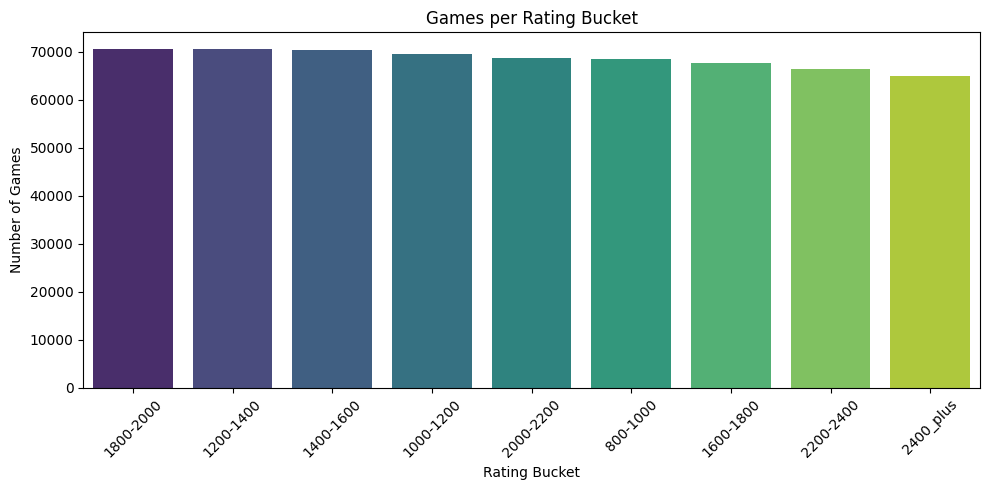

In [10]:
# games per bucket
bucket_stats_sorted = bucket_stats.sort_values('games', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=bucket_stats_sorted.index,
    y=bucket_stats_sorted['games'],
    palette='viridis'
)
plt.title('Games per Rating Bucket')
plt.xlabel('Rating Bucket')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Rating Distribution

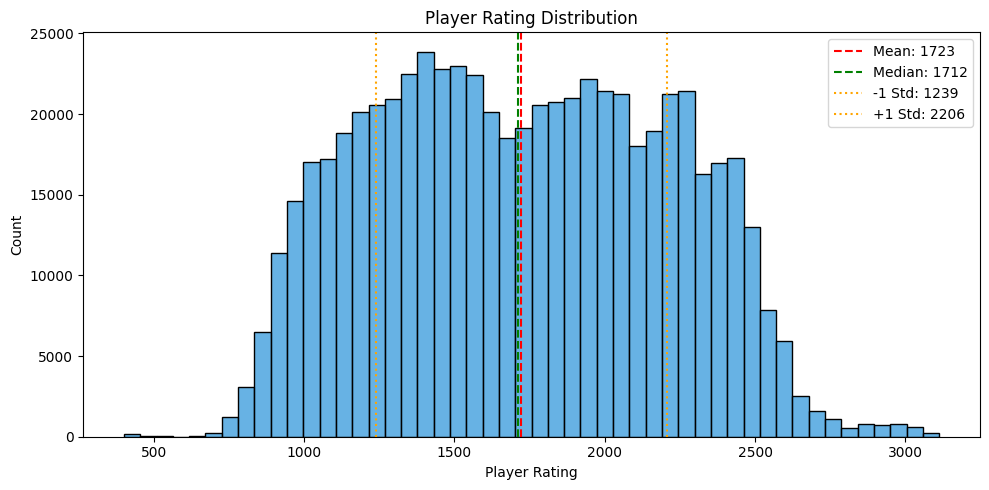

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df_all['player_rating'], bins=50, color='#3498db')
plt.title('Player Rating Distribution')
plt.xlabel('Player Rating')
plt.ylabel('Count')

mean = df_all['player_rating'].mean()
median = df_all['player_rating'].median()
std = df_all['player_rating'].std()

plt.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.0f}')
plt.axvline(median, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median:.0f}')
plt.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'-1 Std: {mean-std:.0f}')
plt.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5, label=f'+1 Std: {mean+std:.0f}')

plt.legend()
plt.tight_layout()
plt.show()

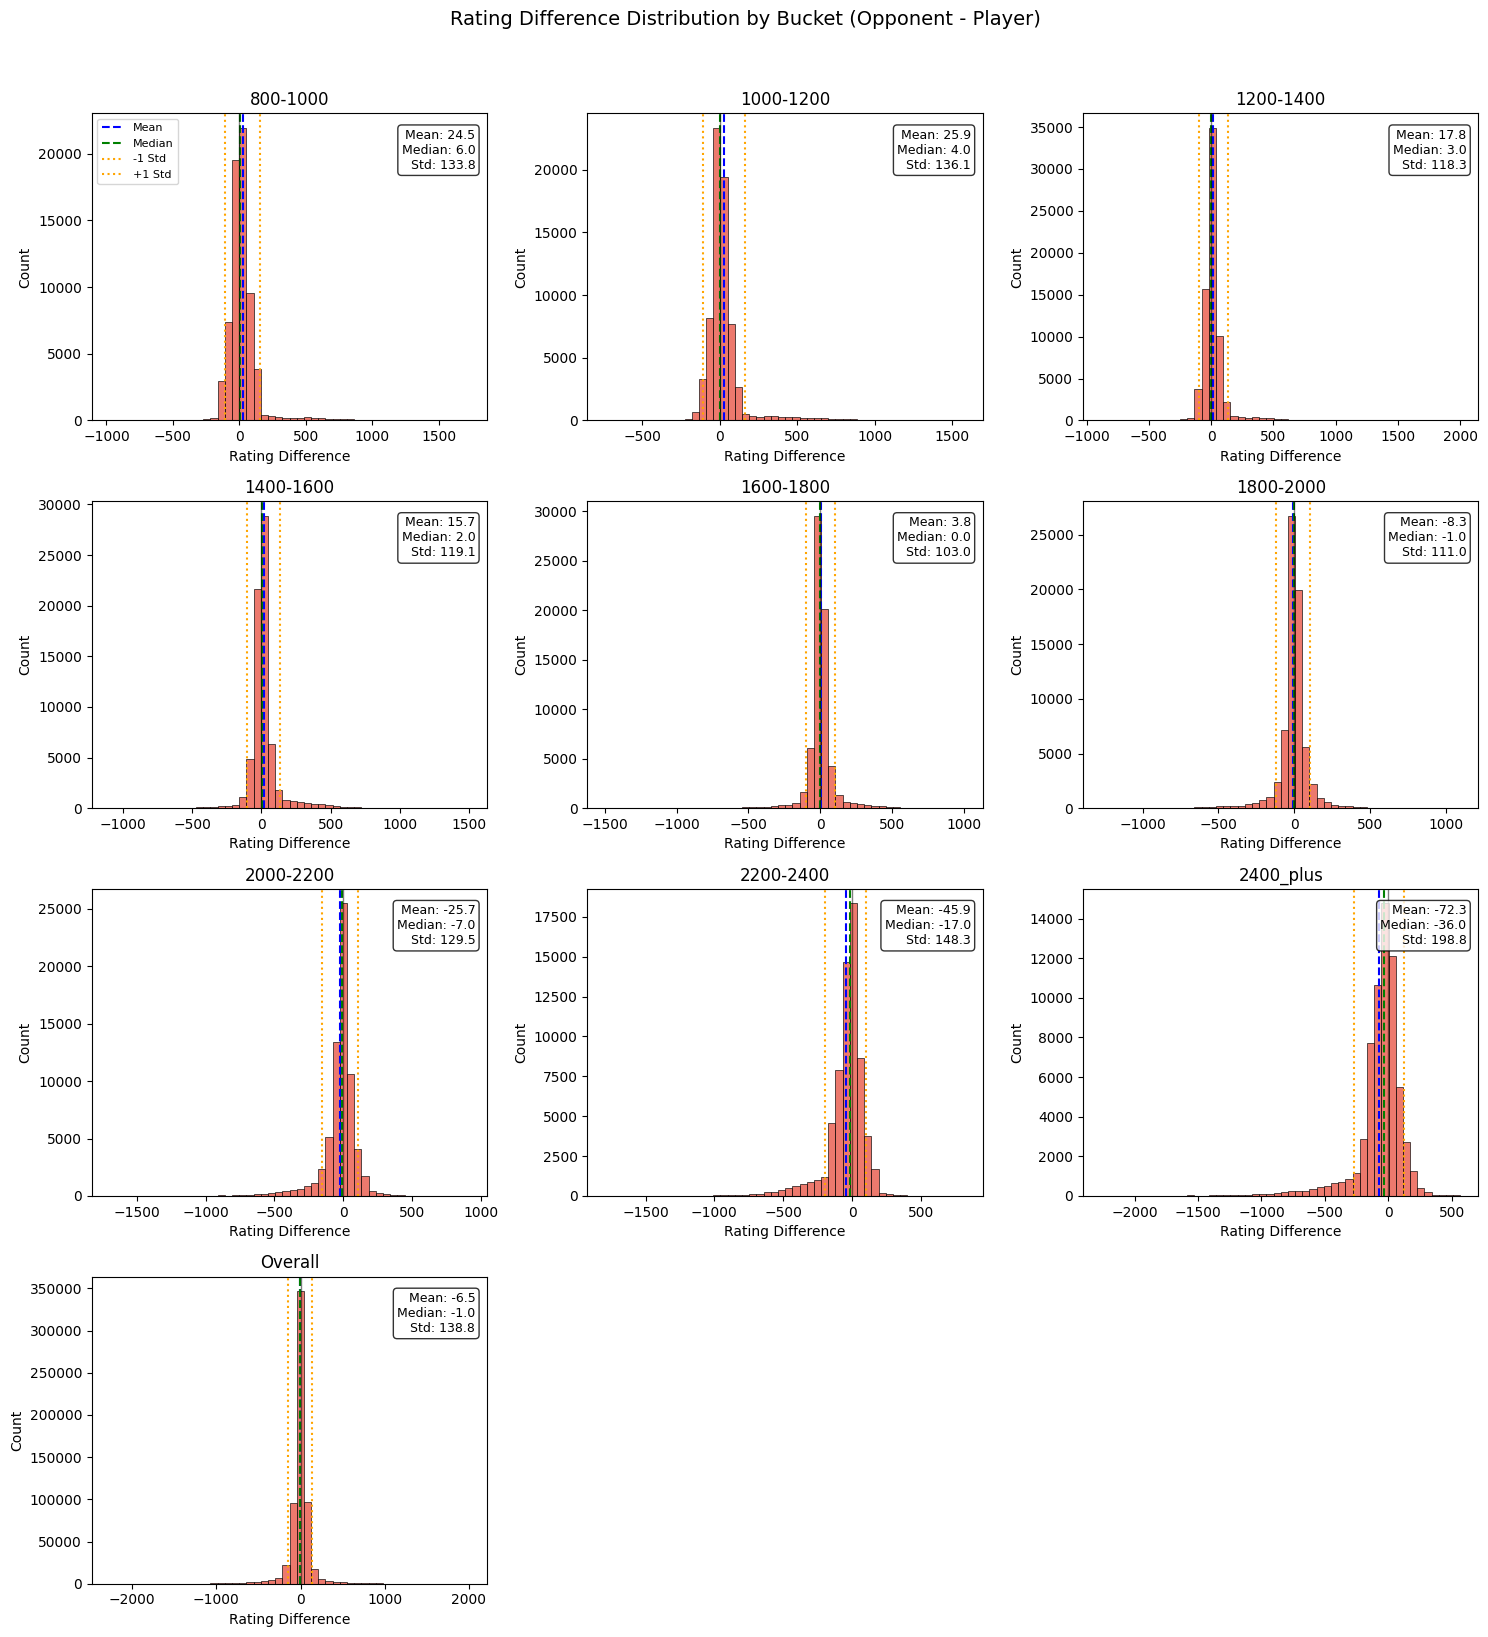

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.flatten()

buckets_list = list(bucket_dataframes.keys()) + ['Overall']

for idx, bucket in enumerate(buckets_list):
    ax = axes[idx]
    
    if bucket == 'Overall':
        data = df_all['rating_diff']
    else:
        data = bucket_dataframes[bucket]['rating_diff']
    
    sns.histplot(data, bins=50, color='#e74c3c', ax=ax)
    
    mean = data.mean()
    median = data.median()
    std = data.std()
    
    ax.axvline(mean, color='blue', linestyle='--', linewidth=1.5, label='Mean')
    ax.axvline(median, color='green', linestyle='--', linewidth=1.5, label='Median')
    ax.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label='-1 Std')
    ax.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5, label='+1 Std')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    stats_text = f"Mean: {mean:.1f}\nMedian: {median:.1f}\nStd: {std:.1f}"
    ax.text(0.97, 0.95, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(bucket)
    ax.set_xlabel('Rating Difference')
    ax.set_ylabel('Count')

for idx in range(len(buckets_list), len(axes)):
    axes[idx].set_visible(False)

axes[0].legend(loc='upper left', fontsize=8)

plt.suptitle('Rating Difference Distribution by Bucket (Opponent - Player)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 3.3 Outcome Distribution

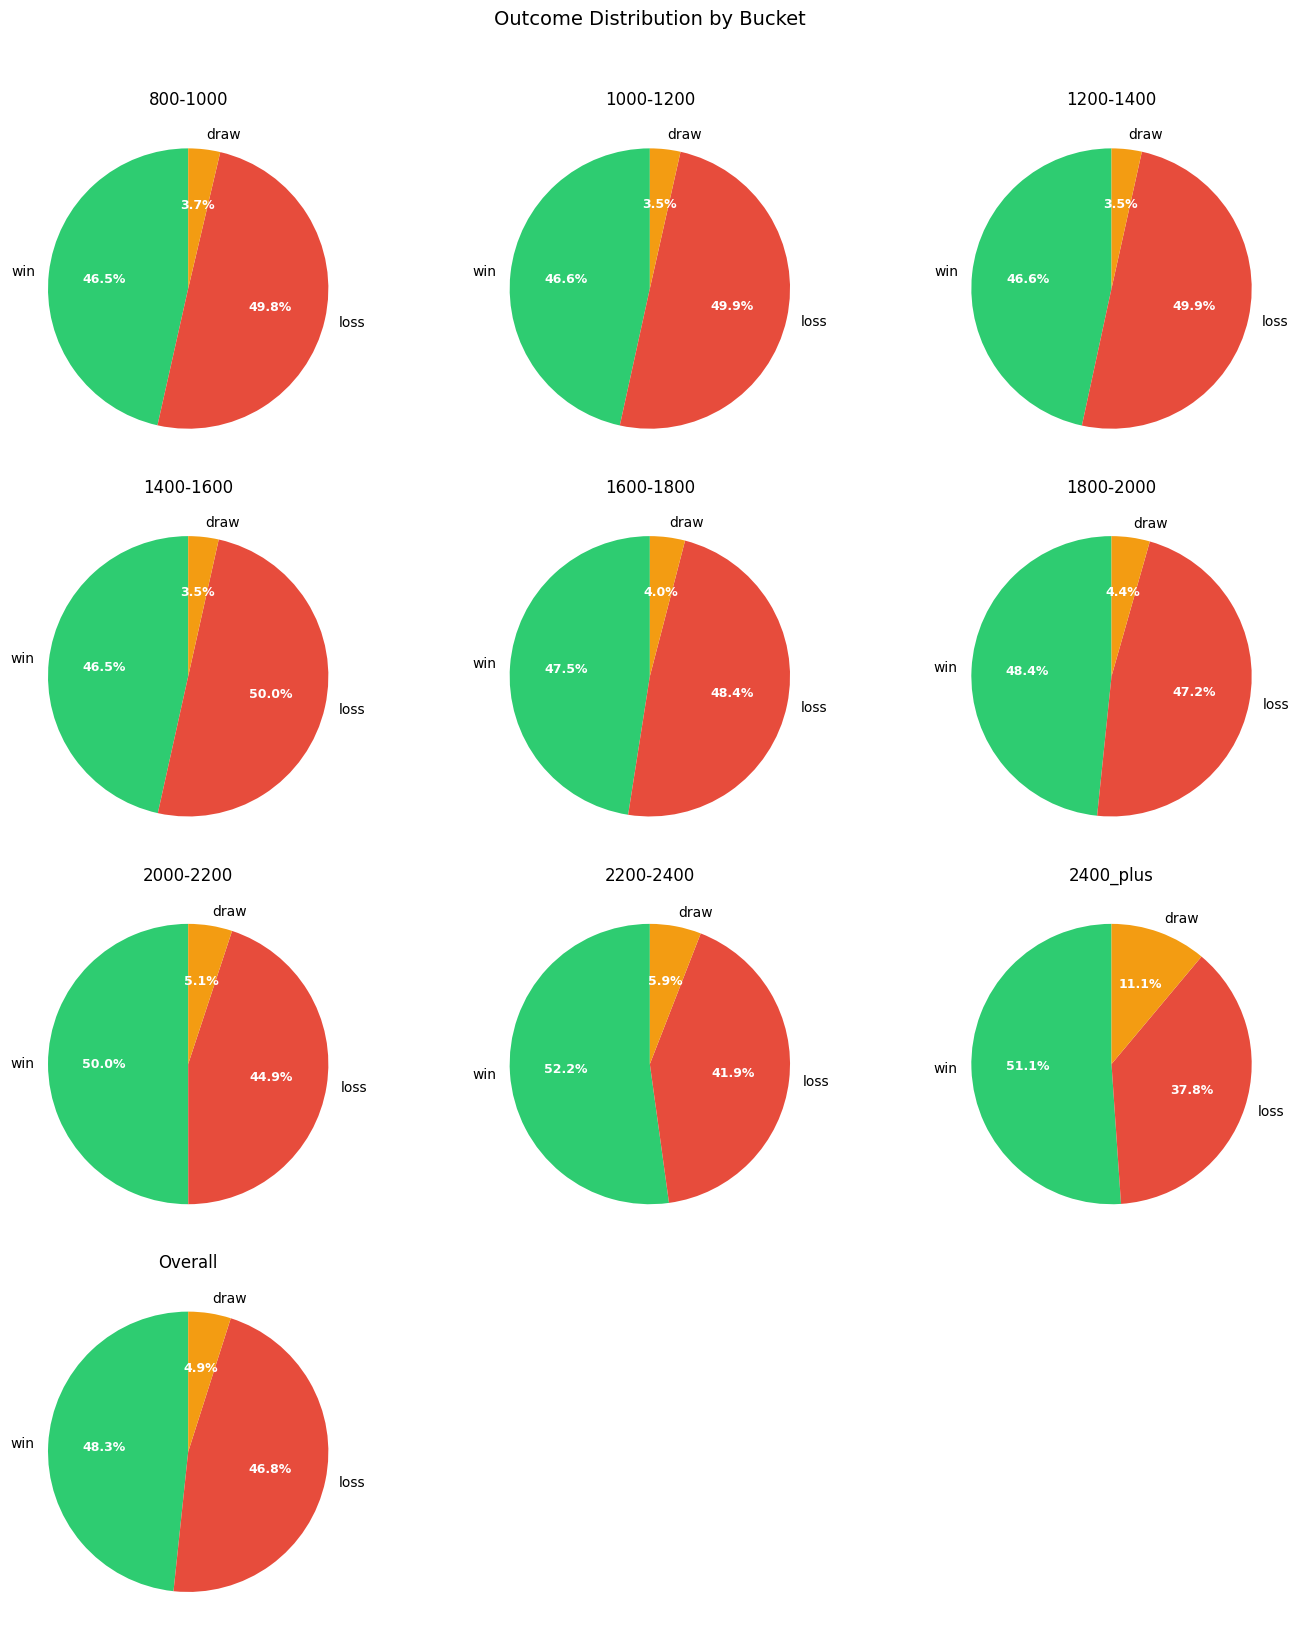

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(14, 16))
axes = axes.flatten()

buckets_list = list(bucket_dataframes.keys()) + ['Overall']

colors = ['#2ecc71', '#e74c3c', '#f39c12'] 

for idx, bucket in enumerate(buckets_list):
    ax = axes[idx]
    
    if bucket == 'Overall':
        data = df_all['outcome'].value_counts()
    else:
        data = bucket_dataframes[bucket]['outcome'].value_counts()
    
    data = data.reindex(['win', 'loss', 'draw'], fill_value=0)
    
    wedges, texts, autotexts = ax.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    
    for autotext in autotexts:
        autotext.set_fontsize(9)
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title(bucket)

for idx in range(len(buckets_list), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Outcome Distribution by Bucket', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

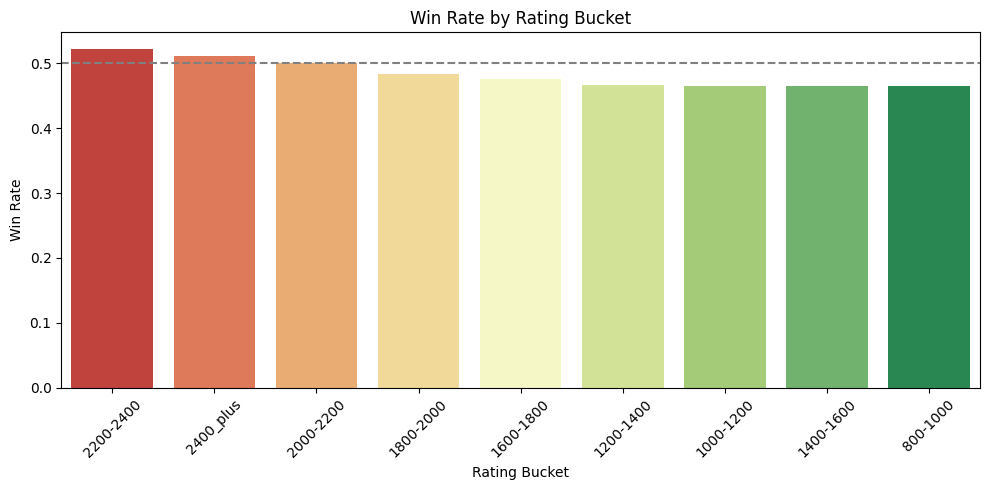

In [14]:
bucket_stats_sorted = bucket_stats.sort_values('win_rate', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=bucket_stats_sorted.index,
    y=bucket_stats_sorted['win_rate'],
    palette='RdYlGn'
)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5)
plt.title('Win Rate by Rating Bucket')
plt.xlabel('Rating Bucket')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.4 Win Rate vs Rating Difference

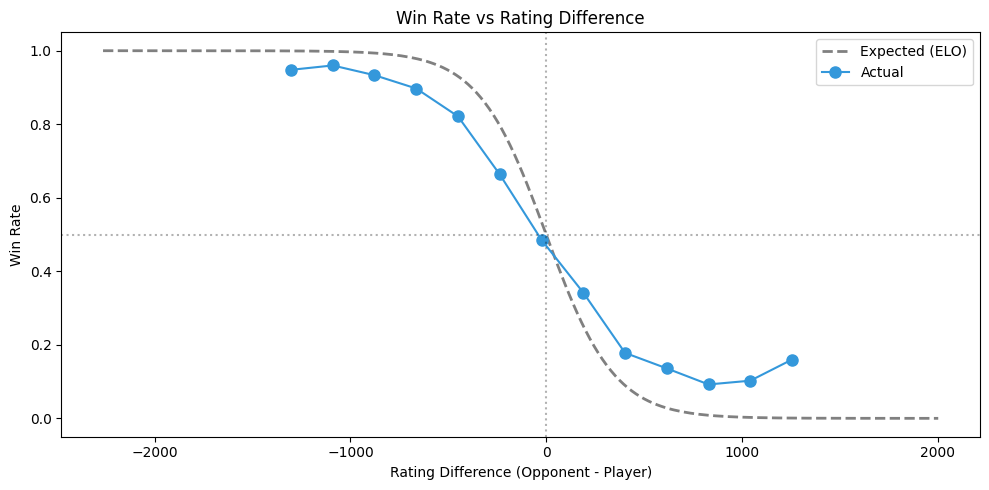

In [15]:
# Bin rating differences and calculate win rate
df_all['rating_diff_bin'] = pd.cut(df_all['rating_diff'], bins=20)
winrate_by_diff = df_all.groupby('rating_diff_bin')['outcome_binary'].agg(['mean', 'count'])
winrate_by_diff = winrate_by_diff[winrate_by_diff['count'] >= 100]

# Get bin midpoints
midpoints = [interval.mid for interval in winrate_by_diff.index]

# Expected ELO curve - TÜM RANGE
x_min = df_all['rating_diff'].min()
x_max = df_all['rating_diff'].max()
x_elo = np.linspace(x_min, x_max, 200)
y_elo = 1 / (1 + 10 ** (x_elo / 400))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_elo, y_elo, '--', color='gray', linewidth=2, label='Expected (ELO)')
plt.plot(midpoints, winrate_by_diff['mean'], 'o-', color='#3498db', markersize=8, label='Actual')

plt.axhline(y=0.5, color='black', linestyle=':', alpha=0.3)
plt.axvline(x=0, color='black', linestyle=':', alpha=0.3)

plt.title('Win Rate vs Rating Difference')
plt.xlabel('Rating Difference (Opponent - Player)')
plt.ylabel('Win Rate')
plt.legend()
plt.tight_layout()
plt.show()

### 3.5 Time Trouble Analysis

In [16]:
bucket_stats_sorted = bucket_stats.sort_values('time_trouble_rate', ascending=False)

fig = px.bar(
    x=bucket_stats_sorted.index,
    y=bucket_stats_sorted['time_trouble_rate'],
    title='Time Trouble Rate by Rating Bucket',
    labels={'x': 'Rating Bucket', 'y': 'Time Trouble Rate'},
    color=bucket_stats_sorted['time_trouble_rate'],
    color_continuous_scale='Reds'
)
fig.update_layout(template=CHART_TEMPLATE, height=400, showlegend=False)
fig.show()

In [17]:
# Win rate by time trouble status
time_trouble_winrate = df_all.groupby(['bucket', 'time_trouble'])['outcome_binary'].mean().unstack()
time_trouble_winrate.columns = ['No Time Trouble', 'Time Trouble']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=time_trouble_winrate.index,
    y=time_trouble_winrate['No Time Trouble'],
    name='No Time Trouble',
    marker_color='#2ecc71'
))

fig.add_trace(go.Bar(
    x=time_trouble_winrate.index,
    y=time_trouble_winrate['Time Trouble'],
    name='Time Trouble',
    marker_color='#e74c3c'
))

fig.update_layout(
    title='Win Rate: Time Trouble vs No Time Trouble',
    xaxis_title='Rating Bucket',
    yaxis_title='Win Rate',
    barmode='group',
    template=CHART_TEMPLATE,
    height=400
)
fig.show()

### 3.6 Color Advantage

In [18]:
# Win rate by color
color_winrate = df_all.groupby(['bucket', 'player_color'])['outcome_binary'].mean().unstack()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=color_winrate.index,
    y=color_winrate['white'],
    name='White',
    marker_color='#f5f5f5',
    marker_line=dict(color='#333', width=1)
))

fig.add_trace(go.Bar(
    x=color_winrate.index,
    y=color_winrate['black'],
    name='Black',
    marker_color='#333'
))

fig.add_hline(y=0.5, line_dash="dash", line_color="gray")

fig.update_layout(
    title='Win Rate by Color',
    xaxis_title='Rating Bucket',
    yaxis_title='Win Rate',
    barmode='group',
    template=CHART_TEMPLATE,
    height=400
)
fig.show()

## 4. Feature Engineering

In [19]:
def calculate_elo_expected(rating_diff):
    """Calculate expected score based on ELO rating difference."""
    return 1 / (1 + 10 ** (rating_diff / 400))


def exponential_weighted_mean(values, decay_rate=0.15):
    """
    Calculate exponentially weighted mean.
    Recent values have higher weight.
    """
    n = len(values)
    if n == 0:
        return 0.5
    
    weights = np.exp(-decay_rate * np.arange(n))
    weights = weights / weights.sum()
    
    return np.sum(values * weights)

In [20]:
def calculate_player_features(df, decay_rate=0.15):
    """
    Calculate rolling player state features.
    DataFrame must be sorted by date (oldest first).
    """
    df = df.copy()
    
    # Form with recency weighting
    def weighted_form(series, window):
        result = []
        for i in range(len(series)):
            if i < 1:
                result.append(0.5)
            else:
                start = max(0, i - window)
                vals = series.iloc[start:i].values
                if len(vals) > 0:
                    result.append(exponential_weighted_mean(vals[::-1], decay_rate))
                else:
                    result.append(0.5)
        return result
    
    df['form_5'] = weighted_form(df['outcome_numeric'], 5)
    df['form_10'] = weighted_form(df['outcome_numeric'], 10)
    df['form_20'] = weighted_form(df['outcome_numeric'], 20)
    
    # Streak
    streaks = []
    streak = 0
    for outcome in df['outcome_numeric']:
        streaks.append(streak)
        if outcome == 1:
            streak = streak + 1 if streak >= 0 else 1
        elif outcome == 0:
            streak = streak - 1 if streak <= 0 else -1
        else:
            streak = 0
    df['streak'] = streaks
    
    # Time trouble rate with recency
    df['time_trouble_rate'] = weighted_form(df['time_trouble'], 20)
    
    # Color performance
    df['white_wr'] = (
        df[df['player_color'] == 'white']['outcome_numeric']
        .expanding().mean()
        .reindex(df.index).ffill().shift(1).fillna(0.5)
    )
    
    df['black_wr'] = (
        df[df['player_color'] == 'black']['outcome_numeric']
        .expanding().mean()
        .reindex(df.index).ffill().shift(1).fillna(0.5)
    )
    
    # Games count
    df['games_played'] = range(len(df))
    
    # Rating trend
    df['rating_trend'] = df['player_rating'].diff(periods=20).shift(1).fillna(0)
    
    # Average game length
    df['avg_game_length'] = (
        df['num_moves'].rolling(window=20, min_periods=1).mean().shift(1).fillna(30)
    )
    
    # ECO category performance
    for eco_cat in ['A', 'B', 'C', 'D', 'E']:
        eco_games = df[df['eco_category'] == eco_cat]['outcome_numeric']
        df[f'eco_{eco_cat}_wr'] = (
            eco_games.expanding().mean()
            .reindex(df.index).ffill().shift(1).fillna(0.5)
        )
    
    # Performance vs ELO expected
    df['elo_expected'] = df['rating_diff'].apply(calculate_elo_expected)
    df['residual'] = df['outcome_numeric'] - df['elo_expected']
    df['residual_ma10'] = df['residual'].rolling(window=10, min_periods=1).mean().shift(1).fillna(0)
    
    return df

In [21]:
def engineer_features_for_bucket(df, decay_rate=0.15, min_games=10):
    """
    Apply feature engineering to all games in a bucket.
    """
    processed_dfs = []
    
    for username, player_df in df.groupby('player_username'):
        player_df = player_df.sort_values('date').reset_index(drop=True)
        processed = calculate_player_features(player_df, decay_rate)
        processed_dfs.append(processed)
    
    if not processed_dfs:
        return pd.DataFrame()
    
    df_features = pd.concat(processed_dfs, ignore_index=True)
    
    # Remove games with insufficient history
    df_features = df_features[df_features['games_played'] >= min_games]
    
    return df_features

In [22]:
def add_opponent_features(df):
    """
    Add opponent features by looking up opponent's stats in the same dataset.
    """
    # Build lookup: (username, game_id) -> features
    feature_cols = [
        'form_5', 'form_10', 'form_20', 'streak', 'time_trouble_rate',
        'white_wr', 'black_wr', 'rating_trend', 'residual_ma10', 'games_played'
    ]
    
    lookup = {}
    for _, row in df.iterrows():
        key = (row['player_username'], row['game_id'])
        lookup[key] = {col: row[col] for col in feature_cols}
    
    # Match opponent features
    opp_data = []
    for _, row in df.iterrows():
        key = (row['opponent_username'], row['game_id'])
        
        if key in lookup:
            opp = lookup[key]
            opp_data.append({
                'opp_form_5': opp['form_5'],
                'opp_form_10': opp['form_10'],
                'opp_streak': opp['streak'],
                'opp_time_trouble_rate': opp['time_trouble_rate'],
                'opp_rating_trend': opp['rating_trend'],
                'opp_residual_ma10': opp['residual_ma10'],
                'has_opponent_data': 1
            })
        else:
            opp_data.append({
                'opp_form_5': 0.5,
                'opp_form_10': 0.5,
                'opp_streak': 0,
                'opp_time_trouble_rate': 0.33,
                'opp_rating_trend': 0,
                'opp_residual_ma10': 0,
                'has_opponent_data': 0
            })
    
    opp_df = pd.DataFrame(opp_data)
    df_with_opp = pd.concat([df.reset_index(drop=True), opp_df], axis=1)
    
    return df_with_opp

In [23]:
def create_model_features(df):
    """
    Create final feature set for model training.
    """
    df = df.copy()
    
    # Core features
    df['elo_expected'] = df['rating_diff'].apply(calculate_elo_expected)
    
    # Player adjusted features
    df['form_5_adj'] = df['form_5'] - 0.5
    df['form_10_adj'] = df['form_10'] - 0.5
    df['form_20_adj'] = df['form_20'] - 0.5
    df['streak_norm'] = df['streak'] / 10
    df['time_management'] = 1 - df['time_trouble_rate']
    
    # Color
    df['is_white'] = (df['player_color'] == 'white').astype(int)
    df['color_advantage'] = df.apply(
        lambda r: r['white_wr'] - 0.5 if r['is_white'] == 1 else r['black_wr'] - 0.5,
        axis=1
    )
    
    df['rating_trend_norm'] = df['rating_trend'] / 100
    
    # Opponent adjusted features
    df['opp_form_5_adj'] = df['opp_form_5'] - 0.5
    df['opp_form_10_adj'] = df['opp_form_10'] - 0.5
    df['opp_streak_norm'] = df['opp_streak'] / 10
    df['opp_time_management'] = 1 - df['opp_time_trouble_rate']
    df['opp_rating_trend_norm'] = df['opp_rating_trend'] / 100
    
    # Difference features
    df['form_5_diff'] = df['form_5_adj'] - df['opp_form_5_adj']
    df['form_10_diff'] = df['form_10_adj'] - df['opp_form_10_adj']
    df['streak_diff'] = df['streak_norm'] - df['opp_streak_norm']
    df['time_mgmt_diff'] = df['time_management'] - df['opp_time_management']
    df['residual_diff'] = df['residual_ma10'] - df['opp_residual_ma10']
    
    return df


# Define feature columns
FEATURE_COLUMNS = [
    # Rating
    'rating_diff', 'elo_expected',
    
    # Player features
    'form_5_adj', 'form_10_adj', 'form_20_adj',
    'streak_norm', 'time_management', 'time_trouble_rate',
    'is_white', 'color_advantage',
    'rating_trend_norm', 'residual_ma10', 'avg_game_length',
    'eco_A_wr', 'eco_B_wr', 'eco_C_wr', 'eco_D_wr', 'eco_E_wr',
    
    # Opponent features
    'opp_form_5_adj', 'opp_form_10_adj', 'opp_streak_norm',
    'opp_time_management', 'opp_rating_trend_norm', 'opp_residual_ma10',
    'has_opponent_data',
    
    # Difference features
    'form_5_diff', 'form_10_diff', 'streak_diff',
    'time_mgmt_diff', 'residual_diff'
]

TARGET_COLUMN = 'outcome_binary'

print(f"Total features: {len(FEATURE_COLUMNS)}")

Total features: 30


In [24]:
def process_bucket_data(df, bucket_name, config):
    """
    Complete feature engineering pipeline for a bucket.
    """
    # Step 1: Player features
    df_feat = engineer_features_for_bucket(
        df, 
        decay_rate=config['recency_decay_rate'],
        min_games=config['min_games_for_stats']
    )
    
    if len(df_feat) == 0:
        return None
    
    # Step 2: Opponent features
    df_feat = add_opponent_features(df_feat)
    
    # Step 3: Model features
    df_feat = create_model_features(df_feat)
    
    # Step 4: Clean
    df_clean = df_feat.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN])
    
    return df_clean

In [25]:
# Process all buckets
processed_buckets = {}

print("Processing buckets...\n")
print(f"{'Bucket':<15} {'Raw':>10} {'Processed':>12} {'Opp Coverage':>15}")
print("-" * 55)

for bucket, df in tqdm(bucket_dataframes.items(), desc="Processing"):
    df_processed = process_bucket_data(df, bucket, CONFIG)
    
    if df_processed is not None and len(df_processed) > 0:
        processed_buckets[bucket] = df_processed
        opp_coverage = df_processed['has_opponent_data'].mean()
        print(f"{bucket:<15} {len(df):>10,} {len(df_processed):>12,} {opp_coverage:>14.1%}")

print("-" * 55)
total_processed = sum(len(df) for df in processed_buckets.values())
print(f"{'TOTAL':<15} {'-':>10} {total_processed:>12,}")

Processing buckets...

Bucket                 Raw    Processed    Opp Coverage
-------------------------------------------------------


Processing:  11%|█         | 1/9 [00:13<01:48, 13.52s/it]

800-1000            68,474       65,124           0.5%


Processing:  22%|██▏       | 2/9 [00:26<01:34, 13.48s/it]

1000-1200           69,638       66,258           0.1%


Processing:  33%|███▎      | 3/9 [00:40<01:20, 13.47s/it]

1200-1400           70,539       67,179           0.1%


Processing:  44%|████▍     | 4/9 [00:54<01:07, 13.56s/it]

1400-1600           70,434       67,054           0.1%


Processing:  56%|█████▌    | 5/9 [01:07<00:53, 13.44s/it]

1600-1800           67,658       64,428           0.2%


Processing:  67%|██████▋   | 6/9 [01:20<00:40, 13.38s/it]

1800-2000           70,545       67,185           0.2%


Processing:  78%|███████▊  | 7/9 [01:34<00:26, 13.39s/it]

2000-2200           68,806       65,516           0.3%


Processing:  89%|████████▉ | 8/9 [01:47<00:13, 13.31s/it]

2200-2400           66,512       63,342           0.9%


Processing: 100%|██████████| 9/9 [01:59<00:00, 13.30s/it]

2400_plus           64,895       61,775           2.0%
-------------------------------------------------------
TOTAL                    -      587,861


## 5. Model Comparison

In [26]:
df_combined = pd.concat(processed_buckets.values(), ignore_index=True)
print(f"Combined processed data: {len(df_combined):,} samples")

Combined processed data: 587,861 samples


In [27]:
df_combined.head()

bucket                    date   game_id player_username  \
0  800-1000 2025-09-02 16:48:35.527  fezWZGbv          a_dobr   
1  800-1000 2025-09-02 16:56:16.308  HL6zTHLM          a_dobr   
2  800-1000 2025-09-02 16:58:38.755  Cz8kQ6uj          a_dobr   
3  800-1000 2025-09-02 17:03:54.075  dMykVPXB          a_dobr   
4  800-1000 2025-09-02 17:07:52.856  MHitduAa          a_dobr   

  opponent_username player_color  player_rating  opponent_rating  rating_diff  \
0     simonsimonson        white           1413             1384          -29   
1     kishoreachess        white           1418             1479           61   
2          saeedkh1        black           1413             1334          -79   
3         umutgurkn        black           1418             1436           18   
4            golcu9        white           1413             1340          -73   

  outcome  outcome_numeric  outcome_binary opening_eco eco_category  \
0     win           1.0000               1         B10            B   
1    loss           0.0000               0         C44            C   
2     win           1.0000               1         D00            D   
3    loss           0.0000               0         C62            C   
4    loss           0.0000               0         C44            C   

   num_moves  time_trouble  final_clock  avg_time_per_move  form_5  form_10  \
0         53             1       0.6500             3.3845  0.8317   0.7814   
1         22             0     100.5200             3.6141  0.8551   0.8119   
2         25             0      97.8300             3.4250  0.7360   0.6588   
3         29             1      17.5300             5.8036  0.7728   0.7263   
4         24             0      61.6200             4.9337  0.5404   0.6251   

   form_20  streak  time_trouble_rate  white_wr  black_wr  ...  opp_form_5  \
0   0.7814       3             0.3828    0.7500    0.7500  ...      0.5000   
1   0.8191       4             0.4892    0.7857    0.7500  ...      0.5000   
2   0.6824      -1             0.4076    0.6875    0.7500  ...      0.5000   
3   0.7340       1             0.3414    0.6875    0.8000  ...      0.5000   
4   0.6175      -1             0.4459    0.6875    0.6667  ...      0.5000   

   opp_form_10  opp_streak  opp_time_trouble_rate  opp_rating_trend  \
0       0.5000           0                 0.3300            0.0000   
1       0.5000           0                 0.3300            0.0000   
2       0.5000           0                 0.3300            0.0000   
3       0.5000           0                 0.3300            0.0000   
4       0.5000           0                 0.3300            0.0000   

   opp_residual_ma10  has_opponent_data  form_5_adj  form_10_adj  form_20_adj  \
0             0.0000                  0      0.3317       0.2814       0.2814   
1             0.0000                  0      0.3551       0.3119       0.3191   
2             0.0000                  0      0.2360       0.1588       0.1824   
3             0.0000                  0      0.2728       0.2263       0.2340   
4             0.0000                  0      0.0404       0.1251       0.1175   

   streak_norm  time_management  is_white  color_advantage  rating_trend_norm  \
0       0.3000           0.6172         1           0.2500             0.0000   
1       0.4000           0.5108         1           0.2857             0.0000   
2      -0.1000           0.5924         0           0.2500             0.0000   
3       0.1000           0.6586         0           0.3000             0.0000   
4      -0.1000           0.5541         1           0.1875             0.0000   

   opp_form_5_adj  opp_form_10_adj  opp_streak_norm  opp_time_management  \
0          0.0000           0.0000           0.0000               0.6700   
1          0.0000           0.0000           0.0000               0.6700   
2          0.0000           0.0000           0.0000               0.6700   
3          0.0000           0.0000           0.0000

In [28]:
# Prepare data
X = df_combined[FEATURE_COLUMNS].values
y = df_combined[TARGET_COLUMN].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

print(f"Training set: {len(X_train):,}")
print(f"Test set: {len(X_test):,}")
print(f"Win rate (train): {y_train.mean():.2%}")
print(f"Win rate (test): {y_test.mean():.2%}")

Training set: 470,288
Test set: 117,573
Win rate (train): 48.32%
Win rate (test): 48.32%


In [29]:
# Baseline: Pure ELO
elo_idx = FEATURE_COLUMNS.index('elo_expected')
y_pred_elo = X_test[:, elo_idx]

elo_auc = roc_auc_score(y_test, y_pred_elo)
elo_acc = accuracy_score(y_test, (y_pred_elo > 0.5).astype(int))
elo_brier = brier_score_loss(y_test, y_pred_elo)

print("Baseline (Pure ELO):")
print(f"  ROC AUC: {elo_auc:.4f}")
print(f"  Accuracy: {elo_acc:.4f}")
print(f"  Brier Score: {elo_brier:.4f}")

Baseline (Pure ELO):
  ROC AUC: 0.5987
  Accuracy: 0.5625
  Brier Score: 0.2411


In [30]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=20,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
}

print(f"Models to compare: {len(models)}")
for name in models:
    print(f"  - {name}")

Models to compare: 5
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM


In [31]:
def evaluate_model(model, X_train, X_test, y_train, y_test, cv_folds=5):
    """
    Train and evaluate a model.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Metrics
    results = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'brier_score': brier_score_loss(y_test, y_pred_proba),
        'log_loss': log_loss(y_test, y_pred_proba),
        'f1': f1_score(y_test, y_pred)
    }
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    results['cv_auc_mean'] = cv_scores.mean()
    results['cv_auc_std'] = cv_scores.std()
    
    return results, model

In [32]:
# Train and evaluate all models
results = {}
trained_models = {}

print("Training models...\n")

for name, model in tqdm(models.items(), desc="Training"):
    model_results, trained_model = evaluate_model(
        model, X_train, X_test, y_train, y_test, CONFIG['cv_folds']
    )
    results[name] = model_results
    trained_models[name] = trained_model

# Create results DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values('roc_auc', ascending=False)

print("\nModel Comparison Results:")
df_results

Training models...



Training: 100%|██████████| 5/5 [35:49<00:00, 429.82s/it]


Model Comparison Results:


roc_auc  accuracy  brier_score  log_loss     f1  \
Gradient Boosting     0.6047    0.5704       0.2384    0.6680 0.4909   
XGBoost               0.6044    0.5700       0.2384    0.6680 0.4929   
LightGBM              0.6044    0.5693       0.2384    0.6679 0.4906   
Random Forest         0.6043    0.5697       0.2386    0.6688 0.4517   
Logistic Regression   0.6022    0.5680       0.2391    0.6698 0.4954   

                     cv_auc_mean  cv_auc_std  
Gradient Boosting         0.6057      0.0014  
XGBoost                   0.6055      0.0014  
LightGBM                  0.6058      0.0013  
Random Forest             0.6056      0.0016  
Logistic Regression       0.6040      0.0012

In [33]:
fig = go.Figure()

fig.add_hline(y=elo_auc, line_dash="dash", line_color="gray",
              annotation_text=f"ELO Baseline ({elo_auc:.4f})")

colors = px.colors.qualitative.Set2

for i, (model_name, row) in enumerate(df_results.iterrows()):
    fig.add_trace(go.Bar(
        x=[model_name],
        y=[row['roc_auc']],
        name=model_name,
        marker_color=colors[i % len(colors)],
        text=f"{row['roc_auc']:.4f}",
        textposition='outside'
    ))

fig.update_layout(
    title='Model Comparison - ROC AUC',
    yaxis_title='ROC AUC',
    template=CHART_TEMPLATE,
    height=500,
    showlegend=False,
    yaxis_range=[0.5, max(df_results['roc_auc']) + 0.02]
)
fig.show()

In [34]:
# ROC Curves
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    name='Random'
))

for i, (name, model) in enumerate(trained_models.items()):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = results[name]['roc_auc']
    
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f"{name} (AUC={auc:.4f})",
        line=dict(color=colors[i % len(colors)])
    ))

fig.update_layout(
    title='ROC Curves',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template=CHART_TEMPLATE,
    height=500,
    legend=dict(x=0.6, y=0.1)
)
fig.show()

In [35]:
# # Select best model
# BEST_MODEL_NAME = df_results.index[0]
# print(f"Best model: {BEST_MODEL_NAME}")
# print(f"ROC AUC: {df_results.loc[BEST_MODEL_NAME, 'roc_auc']:.4f}")
# print(f"Improvement over ELO: +{(df_results.loc[BEST_MODEL_NAME, 'roc_auc'] - elo_auc)*100:.2f}%")

In [36]:
# Select best model 
BEST_MODEL_NAME = 'LightGBM'
print(f"Best model: {BEST_MODEL_NAME}")
print(f"ROC AUC: {df_results.loc[BEST_MODEL_NAME, 'roc_auc']:.4f}")
print(f"Improvement over ELO: +{(df_results.loc[BEST_MODEL_NAME, 'roc_auc'] - elo_auc)*100:.2f}%")

Best model: LightGBM
ROC AUC: 0.6044
Improvement over ELO: +0.57%


## 6. Train Bucket-Specific Models

Train a separate model for each rating bucket.

In [44]:
def get_best_model_instance():
    """
    Return a new instance of the best model.
    """
    # Use the best performing model from comparison
    if BEST_MODEL_NAME == 'LightGBM':
        return lgb.LGBMClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.08,
            num_leaves=31,
            min_child_samples=30,
            reg_alpha=0.1,
            reg_lambda=0.1,
            importance_type='gain',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )
    elif BEST_MODEL_NAME == 'XGBoost':
        return xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.08,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='logloss'
        )
    elif BEST_MODEL_NAME == 'Gradient Boosting':
        return GradientBoostingClassifier(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.08,
            random_state=RANDOM_STATE
        )
    elif BEST_MODEL_NAME == 'Random Forest':
        return RandomForestClassifier(
            n_estimators=150,
            max_depth=10,
            min_samples_leaf=20,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    else:  # Logistic Regression
        return LogisticRegression(
            max_iter=1000,
            random_state=RANDOM_STATE
        )

In [45]:
def train_bucket_model(df, bucket_name, feature_cols, target_col, config):
    """
    Train a model for a specific bucket.
    """
    # Prepare data
    X = df[feature_cols].values
    y = df[target_col].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=config['test_size'],
        random_state=config['random_state'],
        stratify=y
    )
    
    # Train base model
    model = get_best_model_instance()
    model.fit(X_train, y_train)
    
    # Calibrate
    calibrated = CalibratedClassifierCV(model, method='isotonic', cv=5)
    calibrated.fit(X_train, y_train)
    
    # Evaluate
    y_pred_proba = calibrated.predict_proba(X_test)[:, 1]
    y_pred = calibrated.predict(X_test)
    
    # ELO baseline for this bucket
    elo_idx = feature_cols.index('elo_expected')
    y_pred_elo = X_test[:, elo_idx]
    elo_auc = roc_auc_score(y_test, y_pred_elo)
    
    metrics = {
        'bucket': bucket_name,
        'samples': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'elo_auc': elo_auc,
        'model_auc': roc_auc_score(y_test, y_pred_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'brier_score': brier_score_loss(y_test, y_pred_proba),
        'improvement': roc_auc_score(y_test, y_pred_proba) - elo_auc
    }
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = dict(zip(feature_cols, model.feature_importances_))
    else:
        importance = None
    
    return {
        'model': calibrated,
        'base_model': model,
        'metrics': metrics,
        'feature_importance': importance
    }

In [46]:
# Train models for each bucket
bucket_models = {}
bucket_metrics = []

print("Training bucket models...\n")

for bucket, df in tqdm(processed_buckets.items(), desc="Training buckets"):
    result = train_bucket_model(df, bucket, FEATURE_COLUMNS, TARGET_COLUMN, CONFIG)
    bucket_models[bucket] = result
    bucket_metrics.append(result['metrics'])

# Results table
df_bucket_metrics = pd.DataFrame(bucket_metrics)
df_bucket_metrics = df_bucket_metrics.set_index('bucket')

print("\nBucket Model Results:")
df_bucket_metrics[['samples', 'elo_auc', 'model_auc', 'improvement', 'accuracy']]

Training bucket models...



Training buckets: 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


Bucket Model Results:


samples  elo_auc  model_auc  improvement  accuracy
bucket                                                       
800-1000     65124   0.5746     0.5740      -0.0007    0.5574
1000-1200    66258   0.5771     0.5804       0.0033    0.5592
1200-1400    67179   0.5585     0.5593       0.0008    0.5443
1400-1600    67054   0.5687     0.5648      -0.0040    0.5495
1600-1800    64428   0.5720     0.5646      -0.0074    0.5428
1800-2000    67185   0.5919     0.5887      -0.0033    0.5576
2000-2200    65516   0.6101     0.6088      -0.0013    0.5698
2200-2400    63342   0.6382     0.6347      -0.0035    0.5916
2400_plus    61775   0.6794     0.6902       0.0108    0.6282

In [47]:
# Visualize bucket performance
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_bucket_metrics.index,
    y=df_bucket_metrics['elo_auc'],
    name='ELO Baseline',
    marker_color='#bdc3c7'
))

fig.add_trace(go.Bar(
    x=df_bucket_metrics.index,
    y=df_bucket_metrics['model_auc'],
    name='Model',
    marker_color='#3498db'
))

fig.update_layout(
    title='Bucket Model Performance vs ELO Baseline',
    xaxis_title='Rating Bucket',
    yaxis_title='ROC AUC',
    barmode='group',
    template=CHART_TEMPLATE,
    height=450
)
fig.show()

In [48]:
# Improvement by bucket
fig = px.bar(
    x=df_bucket_metrics.index,
    y=df_bucket_metrics['improvement'] * 100,
    title='Model Improvement over ELO by Bucket',
    labels={'x': 'Rating Bucket', 'y': 'Improvement (%)'},
    color=df_bucket_metrics['improvement'] * 100,
    color_continuous_scale='RdYlGn'
)
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(template=CHART_TEMPLATE, height=400, showlegend=False)
fig.show()

## 7. Train Global Model

In [49]:
# Train global model on all data
print("Training global model...")
print(f"Total samples: {len(df_combined):,}")

global_result = train_bucket_model(
    df_combined, 
    'global', 
    FEATURE_COLUMNS, 
    TARGET_COLUMN, 
    CONFIG
)

print("\nGlobal Model Results:")
for key, value in global_result['metrics'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Training global model...
Total samples: 587,861

Global Model Results:
  bucket: global
  samples: 587861
  train_size: 470288
  test_size: 117573
  elo_auc: 0.5987
  model_auc: 0.6049
  accuracy: 0.5697
  brier_score: 0.2383
  improvement: 0.0062


## 8. Feature Importance Analysis

In [50]:
# Global feature importance
if global_result['feature_importance']:
    global_importance = pd.DataFrame({
        'feature': list(global_result['feature_importance'].keys()),
        'importance': list(global_result['feature_importance'].values())
    }).sort_values('importance', ascending=True)
    
    fig = px.bar(
        global_importance.tail(15),
        x='importance',
        y='feature',
        orientation='h',
        title='Global Model - Top 15 Feature Importance',
        color='importance',
        color_continuous_scale='Viridis'
    )
    fig.update_layout(template=CHART_TEMPLATE, height=500, showlegend=False)
    fig.show()

In [51]:
# Compare feature importance across buckets
importance_by_bucket = {}

for bucket, result in bucket_models.items():
    if result['feature_importance']:
        importance_by_bucket[bucket] = result['feature_importance']

if importance_by_bucket:
    df_importance = pd.DataFrame(importance_by_bucket)
    
    # Normalize per bucket
    df_importance_norm = df_importance.div(df_importance.sum())
    
    # Top 10 features by average importance
    top_features = df_importance_norm.mean(axis=1).nlargest(10).index
    
    # Heatmap
    fig = px.imshow(
        df_importance_norm.loc[top_features].T,
        title='Feature Importance by Rating Bucket (Top 10)',
        labels=dict(x='Feature', y='Bucket', color='Importance'),
        color_continuous_scale='Viridis',
        aspect='auto'
    )
    fig.update_layout(template=CHART_TEMPLATE, height=400)
    fig.show()

In [52]:
# Feature importance trend by rating level
if importance_by_bucket:
    key_features = ['rating_diff', 'form_10_diff', 'streak_diff', 'time_mgmt_diff', 'elo_expected']
    
    fig = go.Figure()
    
    for feature in key_features:
        if feature in df_importance_norm.index:
            fig.add_trace(go.Scatter(
                x=list(df_importance_norm.columns),
                y=df_importance_norm.loc[feature],
                mode='lines+markers',
                name=feature
            ))
    
    fig.update_layout(
        title='Key Feature Importance Across Rating Levels',
        xaxis_title='Rating Bucket',
        yaxis_title='Normalized Importance',
        template=CHART_TEMPLATE,
        height=450
    )
    fig.show()

## 9. Final Comparison: Bucket vs Global

In [53]:
# Compare bucket models vs global model on each bucket's test set
comparison_results = []

for bucket, df in processed_buckets.items():
    X = df[FEATURE_COLUMNS].values
    y = df[TARGET_COLUMN].values
    
    _, X_test, _, y_test = train_test_split(
        X, y,
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_state'],
        stratify=y
    )
    
    # Bucket model prediction
    bucket_model = bucket_models[bucket]['model']
    y_pred_bucket = bucket_model.predict_proba(X_test)[:, 1]
    bucket_auc = roc_auc_score(y_test, y_pred_bucket)
    
    # Global model prediction
    global_model = global_result['model']
    y_pred_global = global_model.predict_proba(X_test)[:, 1]
    global_auc = roc_auc_score(y_test, y_pred_global)
    
    # ELO baseline
    elo_idx = FEATURE_COLUMNS.index('elo_expected')
    elo_auc = roc_auc_score(y_test, X_test[:, elo_idx])
    
    comparison_results.append({
        'bucket': bucket,
        'elo_auc': elo_auc,
        'bucket_model_auc': bucket_auc,
        'global_model_auc': global_auc,
        'bucket_vs_global': bucket_auc - global_auc
    })

df_comparison = pd.DataFrame(comparison_results).set_index('bucket')
df_comparison

elo_auc  bucket_model_auc  global_model_auc  bucket_vs_global
bucket                                                                  
800-1000    0.5746            0.5740            0.5931           -0.0192
1000-1200   0.5771            0.5804            0.5971           -0.0167
1200-1400   0.5585            0.5593            0.5760           -0.0167
1400-1600   0.5687            0.5648            0.5847           -0.0199
1600-1800   0.5720            0.5646            0.5858           -0.0213
1800-2000   0.5919            0.5887            0.5978           -0.0091
2000-2200   0.6101            0.6088            0.6216           -0.0128
2200-2400   0.6382            0.6347            0.6491           -0.0144
2400_plus   0.6794            0.6902            0.7035           -0.0133

In [54]:
# Visualize comparison
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_comparison.index,
    y=df_comparison['elo_auc'],
    mode='lines+markers',
    name='ELO Baseline',
    line=dict(dash='dash', color='gray')
))

fig.add_trace(go.Scatter(
    x=df_comparison.index,
    y=df_comparison['global_model_auc'],
    mode='lines+markers',
    name='Global Model',
    line=dict(color='#e74c3c'),
    marker=dict(size=10)
))

fig.add_trace(go.Scatter(
    x=df_comparison.index,
    y=df_comparison['bucket_model_auc'],
    mode='lines+markers',
    name='Bucket Model',
    line=dict(color='#2ecc71'),
    marker=dict(size=10)
))

fig.update_layout(
    title='Model Performance Comparison by Bucket',
    xaxis_title='Rating Bucket',
    yaxis_title='ROC AUC',
    template=CHART_TEMPLATE,
    height=450
)
fig.show()

In [55]:
# Summary statistics
print("SUMMARY")

avg_elo = df_comparison['elo_auc'].mean()
avg_bucket = df_comparison['bucket_model_auc'].mean()
avg_global = df_comparison['global_model_auc'].mean()

print(f"\nAverage ROC AUC:")
print(f"  ELO Baseline:  {avg_elo:.4f}")
print(f"  Global Model:  {avg_global:.4f} (+{(avg_global-avg_elo)*100:.2f}%)")
print(f"  Bucket Models: {avg_bucket:.4f} (+{(avg_bucket-avg_elo)*100:.2f}%)")

print(f"\nBucket vs Global:")
bucket_wins = (df_comparison['bucket_vs_global'] > 0).sum()
print(f"  Bucket model better in {bucket_wins}/{len(df_comparison)} buckets")
print(f"  Average difference: {df_comparison['bucket_vs_global'].mean()*100:+.2f}%")

SUMMARY

Average ROC AUC:
  ELO Baseline:  0.5967
  Global Model:  0.6121 (+1.54%)
  Bucket Models: 0.5962 (+-0.06%)

Bucket vs Global:
  Bucket model better in 0/9 buckets
  Average difference: -1.59%


## 10. Save Models

In [56]:
# Save bucket models
print("Saving models...\n")

for bucket, result in bucket_models.items():
    safe_name = bucket.replace('+', '_plus').replace('-', '_')
    filepath = os.path.join(CONFIG['output_dir'], f"bucket_{safe_name}_model.pkl")
    
    model_package = {
        'model': result['model'],
        'base_model': result['base_model'],
        'bucket': bucket,
        'feature_columns': FEATURE_COLUMNS,
        'metrics': result['metrics'],
        'feature_importance': result['feature_importance'],
        'model_type': BEST_MODEL_NAME,
        'training_date': datetime.now().isoformat()
    }
    
    with open(filepath, 'wb') as f:
        pickle.dump(model_package, f)
    
    print(f"  Saved: {filepath}")

Saving models...

  Saved: models\bucket_800_1000_model.pkl
  Saved: models\bucket_1000_1200_model.pkl
  Saved: models\bucket_1200_1400_model.pkl
  Saved: models\bucket_1400_1600_model.pkl
  Saved: models\bucket_1600_1800_model.pkl
  Saved: models\bucket_1800_2000_model.pkl
  Saved: models\bucket_2000_2200_model.pkl
  Saved: models\bucket_2200_2400_model.pkl
  Saved: models\bucket_2400_plus_model.pkl


In [57]:
# Save global model
filepath = os.path.join(CONFIG['output_dir'], "global_model.pkl")

global_package = {
    'model': global_result['model'],
    'base_model': global_result['base_model'],
    'bucket': 'global',
    'feature_columns': FEATURE_COLUMNS,
    'metrics': global_result['metrics'],
    'feature_importance': global_result['feature_importance'],
    'model_type': BEST_MODEL_NAME,
    'training_date': datetime.now().isoformat(),
    'elo_fallback_threshold': CONFIG['elo_fallback_threshold']
}

with open(filepath, 'wb') as f:
    pickle.dump(global_package, f)

print(f"\n  Saved: {filepath}")


  Saved: models\global_model.pkl


In [58]:
# Save model registry
registry = {
    'buckets': list(bucket_models.keys()),
    'global_model': 'global_model.pkl',
    'bucket_models': {b: f"bucket_{b.replace('+', '_plus').replace('-', '_')}_model.pkl" 
                      for b in bucket_models.keys()},
    'elo_fallback_threshold': CONFIG['elo_fallback_threshold'],
    'feature_columns': FEATURE_COLUMNS,
    'model_type': BEST_MODEL_NAME,
    'created': datetime.now().isoformat()
}

with open(os.path.join(CONFIG['output_dir'], 'model_registry.json'), 'w') as f:
    json.dump(registry, f, indent=2)

print(f"\n  Saved: {CONFIG['output_dir']}/model_registry.json")


  Saved: models/model_registry.json


In [59]:
# Final summary
print("TRAINING COMPLETE")

print(f"\nModels saved to: {CONFIG['output_dir']}/")
print(f"  - 9 bucket models")
print(f"  - 1 global model")
print(f"  - model_registry.json")

print(f"\nModel type: {BEST_MODEL_NAME}")
print(f"Features: {len(FEATURE_COLUMNS)}")
print(f"Total training samples: {len(df_combined):,}")

print(f"\nPerformance:")
print(f"  ELO Baseline: {avg_elo:.4f}")
print(f"  Bucket Models: {avg_bucket:.4f} (+{(avg_bucket-avg_elo)*100:.2f}%)")
print(f"  Global Model: {avg_global:.4f} (+{(avg_global-avg_elo)*100:.2f}%)")

TRAINING COMPLETE

Models saved to: models/
  - 9 bucket models
  - 1 global model
  - model_registry.json

Model type: LightGBM
Features: 30
Total training samples: 587,861

Performance:
  ELO Baseline: 0.5967
  Bucket Models: 0.5962 (+-0.06%)
  Global Model: 0.6121 (+1.54%)
